In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

In [2]:
punkty = gpd.read_file('../data/raw/esa_202305140715CEST.csv')

In [3]:
granice = gpd.read_file('../data/shapes/granice_województw.shp')

## Measurement dataset

In [4]:
punkty.shape

(1613, 13)

In [5]:
punkty.head()

,NAME,STREET,POST_CODE,CITY,LONGITUDE,LATITUDE,HUMIDITY_AVG,PRESSURE_AVG,TEMPERATURE_AVG,PM10_AVG,PM25_AVG,TIMESTAMP,geometry
0,SZKO?A PODSTAWOWA W D?UGO??CE,,19-111,D?UGO??KA,22.8683732,53.2753471,78.30833333333334,1007.9916666666667,9.058333333333334,24.891666666666666,21.291666666666668,2023-05-14 06:00:00.0,None
1,SZKO?A PODSTAWOWA NR 2 IM. KAZIMIERZA BRODZI?...,ORACKA,32-700,BOCHNIA,20.4250867479996,49.9702658831946,69.4,999.0,0.20000000000000004,89.0,51.0,2023-05-14 06:00:00.0,None
2,I LICEUM OG?LNOKSZTA?C?CE IM. HENRYKA SIENKIEW...,UL. 17 MARCA,82-200,MALBORK,19.0379763,54.0361319,75.675,1021.5333333333333,11.866666666666667,22.483333333333334,20.291666666666668,2023-05-14 06:00:00.0,None
3,SZKO?A PODSTAWOWA NR 16 W ZABRZU,UL. J?ZEFA LOMPY,41-806,ZABRZE,18.8139578,50.2870184,76.85833333333333,990.6999999999999,8.799999999999999,27.558333333333334,25.650000000000002,2023-05-14 06:00:00.0,None
4,SZKO?A PODSTAWOWA NR 1 IM. W?ADYS?AWA JAGIE??Y...,G??WNA,32-608,OSIEK,19.2631410879493,49.9511789367323,75.78888888888889,990.3333333333334,6.644444444444444,27.444444444444443,18.444444444444443,2023-05-14 06:00:00.0,None


In [6]:
punkty.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1613 entries, 0 to 1612
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   NAME             1613 non-null   object  
 1   STREET           1613 non-null   object  
 2   POST_CODE        1613 non-null   object  
 3   CITY             1613 non-null   object  
 4   LONGITUDE        1613 non-null   object  
 5   LATITUDE         1613 non-null   object  
 6   HUMIDITY_AVG     1613 non-null   object  
 7   PRESSURE_AVG     1613 non-null   object  
 8   TEMPERATURE_AVG  1613 non-null   object  
 9   PM10_AVG         1613 non-null   object  
 10  PM25_AVG         1613 non-null   object  
 11  TIMESTAMP        1613 non-null   object  
 12  geometry         0 non-null      geometry
dtypes: geometry(1), object(12)
memory usage: 163.9+ KB


In [7]:
punkty['LONGITUDE'] = punkty['LONGITUDE'].astype('float')
punkty['LATITUDE'] = punkty['LATITUDE'].astype('float')
punkty['HUMIDITY_AVG'] = pd.to_numeric(punkty['HUMIDITY_AVG'], errors='coerce')
punkty['PRESSURE_AVG'] = pd.to_numeric(punkty['PRESSURE_AVG'], errors='coerce')
punkty['TEMPERATURE_AVG'] = pd.to_numeric(punkty['TEMPERATURE_AVG'], errors='coerce')
punkty['PM10_AVG'] = pd.to_numeric(punkty['PM10_AVG'], errors='coerce')
punkty['PM25_AVG'] = pd.to_numeric(punkty['PM25_AVG'], errors='coerce')
punkty['TIMESTAMP'] = pd.to_datetime(punkty['TIMESTAMP'])

In [8]:
punkty = punkty.drop(['STREET', 'POST_CODE', 'geometry'], axis=1)

In [9]:
punkty.head()

,NAME,CITY,LONGITUDE,LATITUDE,HUMIDITY_AVG,PRESSURE_AVG,TEMPERATURE_AVG,PM10_AVG,PM25_AVG,TIMESTAMP
0,SZKO?A PODSTAWOWA W D?UGO??CE,D?UGO??KA,22.868373,53.275347,78.308333,1007.991667,9.058333,24.891667,21.291667,2023-05-14 06:00:00
1,SZKO?A PODSTAWOWA NR 2 IM. KAZIMIERZA BRODZI?...,BOCHNIA,20.425087,49.970266,69.400000,999.000000,0.200000,89.000000,51.000000,2023-05-14 06:00:00
2,I LICEUM OG?LNOKSZTA?C?CE IM. HENRYKA SIENKIEW...,MALBORK,19.037976,54.036132,75.675000,1021.533333,11.866667,22.483333,20.291667,2023-05-14 06:00:00
3,SZKO?A PODSTAWOWA NR 16 W ZABRZU,ZABRZE,18.813958,50.287018,76.858333,990.700000,8.800000,27.558333,25.650000,2023-05-14 06:00:00
4,SZKO?A PODSTAWOWA NR 1 IM. W?ADYS?AWA JAGIE??Y...,OSIEK,19.263141,49.951179,75.788889,990.333333,6.644444,27.444444,18.444444,2023-05-14 06:00:00


In [10]:
punkty.describe()

,LONGITUDE,LATITUDE,HUMIDITY_AVG,PRESSURE_AVG,TEMPERATURE_AVG,PM10_AVG,PM25_AVG
count,1613.000000,1613.000000,1610.000000,1610.000000,1610.000000,1613.000000,1613.000000
mean,18.916736,51.235502,83.490114,999.472115,8.321663,28.079793,21.845077
std,2.297866,2.845879,12.921988,14.717586,3.580090,12.372833,9.728757
min,0.000000,0.000000,0.000000,930.000000,-40.000000,0.000000,0.000000
25%,16.990947,50.211892,76.937500,991.333333,6.858333,20.300000,15.216667
50%,18.940100,51.150780,84.929167,1001.091667,8.191667,27.466667,21.466667
75%,20.684812,52.387907,92.322917,1009.864583,9.856250,34.508333,27.300000
max,23.873936,54.661981,100.000000,1100.000000,39.461667,183.533333,112.106667


## Shape data

In [11]:
granice.head()

,JPT_SJR_KO,JPT_KOD_JE,JPT_NAZWA_,JPT_JOR_ID,WERSJA_OD,WERSJA_DO,WAZNY_OD,WAZNY_DO,JPT_KOD__1,JPT_NAZWA1,...,JPT_KJ_I_1,JPT_KJ_I_2,JPT_OPIS,JPT_SPS_KO,ID_BUFOR_1,JPT_ID,JPT_KJ_I_3,Shape_Leng,Shape_Area,geometry
0,WOJ,24,śląskie,0,2017-10-10,NaN,2012-09-26,NaN,NaN,NaN,...,24,NaN,NaN,UZG,0,1331323,NaN,12.136952,1.557335,"MULTIPOLYGON (((18.91685 51.09608, 18.91677 51..."
1,WOJ,16,opolskie,0,2017-10-10,NaN,2012-09-26,NaN,NaN,NaN,...,16,NaN,NaN,UZG,0,1331326,NaN,9.005207,1.196205,"POLYGON ((17.81203 51.18669, 17.81209 51.18670..."
2,WOJ,26,świętokrzyskie,0,2012-09-26,NaN,2012-09-26,NaN,NaN,NaN,...,26,NaN,NaN,UZG,0,829374,NaN,9.264959,1.491827,"POLYGON ((19.70430 50.75239, 19.70443 50.75248..."
3,WOJ,22,pomorskie,0,2020-04-09,NaN,2012-09-26,NaN,NaN,NaN,...,22,NaN,NaN,UZG,0,1358902,NaN,13.167595,2.520630,"POLYGON ((17.66483 54.78297, 17.66653 54.78334..."
4,WOJ,20,podlaskie,0,2019-03-21,NaN,2012-09-26,NaN,NaN,NaN,...,20,NaN,NaN,UZG,0,1353685,NaN,11.101166,2.718484,"POLYGON ((21.98108 52.97859, 21.98078 52.97861..."


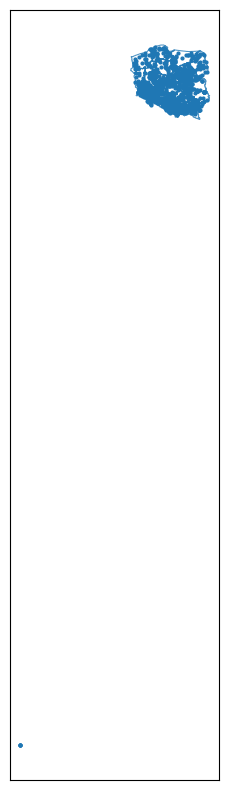

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
granice.boundary.plot(ax=ax, linewidth=0.75, alpha=0.8)
punkty.plot(ax=ax, kind='scatter', x='LONGITUDE', y='LATITUDE', s=4)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)